In [1]:
import pandas as pd
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from html import unescape
import re
import spacy
from titlecase import titlecase
import matplotlib.pyplot as plt
import math
import torch.nn.functional as F

In [2]:
# load data
processed_path = "./processed_data.parquet"
df = pd.read_parquet(processed_path)

# load vocab
vocab_df = pd.read_csv("./vocab.csv")
vocab = {word: idx for word, idx in zip(vocab_df["word"], vocab_df["id"])}
reverse_vocab = {idx: word for word, idx in vocab.items()}  # get reverse vocab

pad_idx = vocab['<pad>']
unk_idx = vocab['<unk>']
sos_idx = vocab['<start>']
eos_idx = vocab['<end>']

In [3]:
def collate_fn(batch):
    """
    batch: List of (input_seq, target_seq)
    """
    input_seqs  = [torch.tensor(item[0], dtype=torch.long) for item in batch]
    target_seqs = [torch.tensor(item[1], dtype=torch.long) for item in batch]

    # padding to the max length in batch
    padded_inputs = pad_sequence(input_seqs,
                                 batch_first=True,
                                 padding_value=pad_idx)

    padded_targets = pad_sequence(target_seqs,
                                  batch_first=True,
                                  padding_value=pad_idx)

    return padded_inputs, padded_targets

In [4]:
class AGNewsDataset(Dataset):
    def __init__(self, dataframe, input_col="desc_seq", target_col="title_seq",
                 max_input_len=200, max_target_len=20):
        self.sos_idx = vocab['<start>']
        self.eos_idx = vocab['<end>']
        self.pad_idx = vocab['<pad>']
        self.max_input_len = max_input_len
        self.max_target_len = max_target_len

        self.samples = []
        for idx, row in dataframe.iterrows():
            input_seq = self._process_seq(row[input_col].tolist(), self.max_input_len, is_target=False)
            target_seq = self._process_seq(row[target_col].tolist(), self.max_target_len, is_target=True)

            if self._is_valid(input_seq) and self._is_valid(target_seq):
                self.samples.append((input_seq, target_seq))

    def _process_seq(self, raw_seq, max_len, is_target):
        """ensure the seq structure：[<start>, tokens..., <end>, <pad>...]"""
        filtered = [x for x in raw_seq if x not in (self.sos_idx, self.eos_idx, self.pad_idx)]

        content_max_len = max_len - 2  
        truncated = filtered[:content_max_len]

        processed = [self.sos_idx] + truncated + [self.eos_idx]

        # padding to max_len
        if len(processed) < max_len:
            processed += [self.pad_idx] * (max_len - len(processed))
        else:
            processed = processed[:max_len]  
            processed[-1] = self.eos_idx  

        return processed

    def _is_valid(self, seq):
        """ensure the seq structure：[<start>, tokens..., <end>]"""
        has_start = self.sos_idx in seq
        has_end = self.eos_idx in seq
        start_pos = seq.index(self.sos_idx) if has_start else -1
        end_pos = seq.index(self.eos_idx) if has_end else -1
        content = seq[start_pos+1:end_pos] if (has_start and has_end) else []
        return has_start and has_end and (len(content) >= 1)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [5]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = AGNewsDataset(train_df, input_col="desc_seq", target_col="title_seq",
                              max_input_len=200, max_target_len=20)
test_dataset  = AGNewsDataset(test_df, input_col="desc_seq", target_col="title_seq",
                              max_input_len=200, max_target_len=20)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)
test_dataloader  = DataLoader(test_dataset,  batch_size=128, shuffle=False, collate_fn=collate_fn)

In [6]:
class TransformerConfig:
    def __init__(self):
        self.vocab_size = 37943  
        self.pad_idx = 0
        self.sos_idx = 2
        self.eos_idx = 3

        self.d_model = 512
        self.nhead = 8
        self.num_encoder_layers = 6
        self.num_decoder_layers = 6
        self.dim_feedforward = 2048
        self.dropout = 0.2

        self.enc_max_len = 200
        self.dec_max_len = 20

        self.share_final_proj = False

In [7]:
def generate_square_subsequent_mask(sz: int) -> torch.Tensor:
    """Generate boolean causal mask for transformer decoder"""
    mask = torch.triu(torch.ones(sz, sz, dtype=torch.bool), diagonal=1)
    return mask  # [sz, sz], dtype=torch.bool

In [8]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.2, max_len: int = 500):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Initialize positional encoding matrix [max_len, d_model]
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(max_len, dtype=torch.float).unsqueeze(1)  # [max_len, 1]

        div_term = torch.exp(
            torch.arange(0, d_model, 2, dtype=torch.float) *
            (-math.log(10000.0) / d_model)  
        )  # [d_model/2]

        # Apply trigonometric functions to even and odd positions
        pe[:, 0::2] = torch.sin(position * div_term)  # Even indices: sine
        pe[:, 1::2] = torch.cos(position * div_term)  # Odd indices: cosine

        self.register_buffer('pe', pe)

        # Numerical range validation (commented out by default)
        # print(f"PE value range - min: {pe.min().item():.4f}, max: {pe.max().item():.4f}")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:x.size(1), :].unsqueeze(0)
        return self.dropout(x)

In [9]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, nhead: int, dropout: float = 0.2):
        super().__init__()
        assert d_model % nhead == 0, "d_model must be divisible by nhead"

        self.d_model = d_model
        self.nhead = nhead
        self.head_dim = d_model // nhead

        # Define linear projection layers
        self.Wq = nn.Linear(d_model, d_model)  # Query projection
        self.Wk = nn.Linear(d_model, d_model)  # Key projection
        self.Wv = nn.Linear(d_model, d_model)  # Value projection
        self.out_proj = nn.Linear(d_model, d_model)  # Final output projection

        self.dropout = nn.Dropout(dropout)

    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor,
                key_padding_mask: torch.Tensor = None,  # Shape: [batch_size, seq_len]
                attn_mask: torch.Tensor = None):         # Shape: [tgt_len, src_len]
        """
        query: [batch_size, tgt_len, d_model]
        key:   [batch_size, src_len, d_model]
        value: [batch_size, src_len, d_model]
        
        returns：
        attn_output: [batch_size, tgt_len, d_model]
        attn_weights: [batch_size, nhead, tgt_len, src_len]
        """
        batch_size = query.size(0)

        # Step 1: Linear projections and multi-head splitting
        Q = self.Wq(query).view(batch_size, -1, self.nhead, self.head_dim).transpose(1, 2)  # [B, nh, T, hd]
        K = self.Wk(key).view(batch_size, -1, self.nhead, self.head_dim).transpose(1, 2)      # [B, nh, S, hd]
        V = self.Wv(value).view(batch_size, -1, self.nhead, self.head_dim).transpose(1, 2)   # [B, nh, S, hd]

        # Step 2: Compute scaled dot-product attention
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)  # [B, nh, T, S]

        # Step 3: Apply attention mask (causal mask)
        if attn_mask is not None:
            # [T, S] -> [B, nh, T, S]
            attn_scores.masked_fill_(attn_mask.unsqueeze(0).unsqueeze(0), float('-inf'))

        # Step 4: Apply key padding mask
        if key_padding_mask is not None:
            # [B, S] -> [B, 1, 1, S]
            key_padding_mask = key_padding_mask.view(batch_size, 1, 1, -1)
            attn_scores = attn_scores.masked_fill(key_padding_mask, float('-inf'))

        # Step 5: Compute attention weights
        attn_weights = F.softmax(attn_scores, dim=-1)  # [B, nh, T, S]
        attn_weights = self.dropout(attn_weights)

        # Step 6: Compute context vectors
        context = torch.matmul(attn_weights, V)  # [B, nh, T, hd]

        # Step 7: Combine multi-head outputs
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)  # [B, T, d_model]

        # Step 8: Final output projection
        attn_output = self.out_proj(context)

        return attn_output, attn_weights

In [10]:
class FeedForward(nn.Module):
    def __init__(self, d_model: int, dim_feedforward: int, dropout: float = 0.2):
        super().__init__()
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        # Initialize parameters (optional but recommended)
        self._reset_parameters()

    def _reset_parameters(self):
        """Xavier uniform initialization for linear layers"""
        nn.init.xavier_uniform_(self.linear1.weight)
        nn.init.xavier_uniform_(self.linear2.weight)
        nn.init.constant_(self.linear1.bias, 0.)
        nn.init.constant_(self.linear2.bias, 0.)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Input tensor of shape [batch_size, seq_len, d_model]
            
        Returns:
            Output tensor of shape [batch_size, seq_len, d_model]
        """
        x = self.linear1(x)        # [B, L, dim_feedforward]
        x = self.activation(x)      # Non-linear activation
        x = self.dropout(x)         # Apply dropout regularization
        x = self.linear2(x)         # [B, L, d_model]
        return x

In [11]:
class EncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.self_attn = MultiHeadAttention(
            d_model=config.d_model,
            nhead=config.nhead,
            dropout=config.dropout
        )
        self.ff = FeedForward(
            d_model=config.d_model,
            dim_feedforward=config.dim_feedforward,
            dropout=config.dropout
        )
        self.norm1 = nn.LayerNorm(config.d_model)
        self.norm2 = nn.LayerNorm(config.d_model)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, src: torch.Tensor,
                src_mask: torch.Tensor = None,
                src_key_padding_mask: torch.Tensor = None) -> torch.Tensor:
        """
        Args:
            src: Input sequence [batch_size, src_seq_len, d_model]
            src_mask: Optional attention mask [src_seq_len, src_seq_len] 
                     (typically not needed for encoder)
            src_key_padding_mask: Boolean mask [batch_size, src_seq_len] 
                                 (True indicates padding positions)
        
        Returns:
            Encoded output [batch_size, src_seq_len, d_model]
        """
        # Self-attention sublayer
        attn_output, _ = self.self_attn(
            query=src,  # [B, L, D]
            key=src,    # [B, L, D]
            value=src,  # [B, L, D]
            attn_mask=src_mask,              
            key_padding_mask=src_key_padding_mask  # Filter padding positions
        )

        # Residual connection + LayerNorm
        src = src + self.dropout(attn_output)  # [B, L, D] + [B, L, D] → [B, L, D]
        src = self.norm1(src)  # Maintain dimension

        # Feed-forward sublayer
        ff_output = self.ff(src)  # [B, L, D] → [B, L, D]

        # Residual connection + LayerNorm
        src = src + self.dropout(ff_output)  # [B, L, D] + [B, L, D] → [B, L, D]
        src = self.norm2(src)

        return src

In [12]:
class Encoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embedding = nn.Embedding(
            num_embeddings=config.vocab_size,
            embedding_dim=config.d_model,
            padding_idx=config.pad_idx
        )
        self.pos_encoder = PositionalEncoding(
            d_model=config.d_model,
            dropout=config.dropout,
            max_len=config.enc_max_len
        )
        self.layers = nn.ModuleList([
            EncoderLayer(config)
            for _ in range(config.num_encoder_layers)
        ])

    def forward(self, src: torch.Tensor,
                src_key_padding_mask: torch.Tensor = None) -> torch.Tensor:
        """
        Args:
            src: Input token indices [batch_size, src_seq_len]
            src_key_padding_mask: Boolean mask [batch_size, src_seq_len] 
                                 (True indicates padding positions)
        
        Returns:
            Encoded sequence [batch_size, src_seq_len, d_model]
        """
        # 1. Embedding layer
        src = self.embedding(src)  # [B, L] → [B, L, D]
        src = self.pos_encoder(src)  # Add positional encodings

        # 2. Process through encoder layers
        for layer in self.layers:
            src = layer(
                src=src,
                src_mask=None,  # Encoder doesn't need causal masking
                src_key_padding_mask=src_key_padding_mask
            )

        return src

In [13]:
class DecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        # Self-attention mechanism (processes target sequence)
        self.self_attn = MultiHeadAttention(
            d_model=config.d_model,
            nhead=config.nhead,
            dropout=config.dropout
        )
        # Encoder-decoder cross attention mechanism
        self.cross_attn = MultiHeadAttention(
            d_model=config.d_model,
            nhead=config.nhead,
            dropout=config.dropout
        )
        # Feed-forward network
        self.ff = FeedForward(
            d_model=config.d_model,
            dim_feedforward=config.dim_feedforward,
            dropout=config.dropout
        )
        # Three normalization layers
        self.norm1 = nn.LayerNorm(config.d_model)
        self.norm2 = nn.LayerNorm(config.d_model)
        self.norm3 = nn.LayerNorm(config.d_model)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, tgt: torch.Tensor, memory: torch.Tensor,
                tgt_mask: torch.Tensor = None,
                memory_mask: torch.Tensor = None,
                tgt_key_padding_mask: torch.Tensor = None,
                memory_key_padding_mask: torch.Tensor = None) -> torch.Tensor:
        """
        Args:
            tgt: Target sequence [batch_size, tgt_seq_len, d_model]
            memory: Encoder output [batch_size, src_seq_len, d_model]
            tgt_mask: Target sequence causal mask [tgt_seq_len, tgt_seq_len]
            tgt_key_padding_mask: Target padding mask [batch_size, tgt_seq_len]
            memory_key_padding_mask: Source padding mask [batch_size, src_seq_len]
        """
        # Self-attention sublayer
        attn_output, _ = self.self_attn(
            query=tgt,
            key=tgt,
            value=tgt,
            attn_mask=tgt_mask,                 # Causal mask
            key_padding_mask=tgt_key_padding_mask  # Target padding
        )
        tgt = tgt + self.dropout(attn_output)
        tgt = self.norm1(tgt)  # [B, T, D]

        # Encoder-decoder attention sublayer
        cross_output, _ = self.cross_attn(
            query=tgt,          # Query from decoder
            key=memory,         # Key from encoder
            value=memory,       # Value from encoder
            key_padding_mask=memory_key_padding_mask  # Source padding
        )
        tgt = tgt + self.dropout(cross_output)
        tgt = self.norm2(tgt)  # [B, T, D]

        # Feed-forward sublayer
        ff_output = self.ff(tgt)
        tgt = tgt + self.dropout(ff_output)
        tgt = self.norm3(tgt)  # [B, T, D]

        return tgt

In [14]:
class Decoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embedding = nn.Embedding(
            num_embeddings=config.vocab_size,
            embedding_dim=config.d_model,
            padding_idx=config.pad_idx
        )
        self.pos_encoder = PositionalEncoding(
            d_model=config.d_model,
            dropout=config.dropout,
            max_len=config.dec_max_len
        )
        self.layers = nn.ModuleList([
            DecoderLayer(config)
            for _ in range(config.num_decoder_layers)
        ])
        # Final output projection to vocabulary size
        self.output_proj = nn.Linear(config.d_model, config.vocab_size)

    def forward(self, tgt: torch.Tensor, memory: torch.Tensor,
                tgt_mask: torch.Tensor = None,
                memory_key_padding_mask: torch.Tensor = None,
                tgt_key_padding_mask: torch.Tensor = None) -> torch.Tensor:
        """
        Args:
            tgt: Target sequence token indices [batch_size, tgt_seq_len]
            memory: Encoder output [batch_size, src_seq_len, d_model]
            tgt_mask: Target attention mask
            memory_key_padding_mask: Memory padding mask
            tgt_key_padding_mask: Target padding mask
            
        Returns:
            Output logits [batch_size, tgt_seq_len, vocab_size]
        """
        # Embedding layer with positional encoding
        tgt = self.embedding(tgt)  # [B, T] → [B, T, D]
        tgt = self.pos_encoder(tgt)  # [B, T, D]

        # 逐层处理
        for layer in self.layers:
            tgt = layer(
                tgt=tgt,
                memory=memory,
                tgt_mask=tgt_mask,
                memory_key_padding_mask=memory_key_padding_mask,
                tgt_key_padding_mask=tgt_key_padding_mask
            )

        # Final projection to vocabulary dimension
        output = self.output_proj(tgt)  # [B, T, vocab_size]
        return output

In [15]:
class Transformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # Encoder components
        self.encoder = Encoder(config)

        # Decoder components
        self.decoder = Decoder(config)

        # Weight sharing logic (optional)
        self._init_weights()

    def _init_weights(self):
        """Weight initialization strategy"""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

        # Share embedding matrix between encoder/decoder
        self.decoder.embedding.weight = self.encoder.embedding.weight
        if self.config.share_final_proj:
            self.decoder.output_proj.weight = self.encoder.embedding.weight

    def forward(self, src: torch.Tensor, tgt: torch.Tensor,
                src_key_padding_mask: torch.Tensor = None,
                tgt_key_padding_mask: torch.Tensor = None) -> torch.Tensor:
        """
        Full forward propagation process
        Args:
            src: Source sequence [batch_size, src_len]
            tgt: Target sequence [batch_size, tgt_len]
        
        Returns:
            logits: [batch_size, tgt_len, vocab_size]
        """
        # Generate causal mask for target sequence
        tgt_mask = self.generate_tgt_mask(tgt.size(1)).to(src.device)  # [tgt_len, tgt_len]

        # Encoding phase
        memory = self.encoder(
            src=src,
            src_key_padding_mask=src_key_padding_mask
        )  # [B, S, D]

        # Decoding phase
        logits = self.decoder(
            tgt=tgt,
            memory=memory,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            memory_key_padding_mask=src_key_padding_mask
        )  # [B, T, V]

        return logits

    @staticmethod
    def generate_tgt_mask(size: int) -> torch.Tensor:
        """Generate causal mask (upper triangular as True)"""
        return generate_square_subsequent_mask(size)

    def encode(self, src: torch.Tensor, src_key_padding_mask: torch.Tensor) -> torch.Tensor:  
        """Standalone encoding method (for inference)"""
        return self.encoder(src, src_key_padding_mask=src_key_padding_mask) 

    def decode(self, tgt: torch.Tensor, memory: torch.Tensor,
               tgt_mask: torch.Tensor, memory_key_padding_mask: torch.Tensor) -> torch.Tensor:  
        """Standalone decoding method (for inference)"""
        return self.decoder(
            tgt=tgt,
            memory=memory,
            tgt_mask=tgt_mask,
            memory_key_padding_mask=memory_key_padding_mask  
        )

In [16]:
config = TransformerConfig()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = Transformer(config).to(device)

# Define optimizer and loss function
d_model = 512
warmup_steps = 7000 # 10 epochs

optimizer = optim.Adam(
    model.parameters(),
    lr=d_model**-0.5,
    betas=(0.9, 0.98),
    eps=1e-9,
    weight_decay=0.0
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda step: min(
        (step + 1)**-0.5,
        (step + 1) * (warmup_steps**-1.5)
    )
)
criterion = torch.nn.CrossEntropyLoss(ignore_index=config.pad_idx)

def train_epoch(model, dataloader, optimizer, criterion, scheduler, device):  # 添加scheduler参数
    model.train()
    total_loss = 0
    progress_bar = tqdm(dataloader, desc="Training", leave=False)

    for batch in progress_bar:
        src, tgt = batch
        src, tgt = src.to(device), tgt.to(device)

        # Forward pass
        decoder_input = tgt[:, :-1]  # remove the last token
        labels = tgt[:, 1:]          # remove the first token

        # Create masks
        src_pad_mask = (src == config.pad_idx)
        tgt_pad_mask = (decoder_input == config.pad_idx)

        optimizer.zero_grad()

        logits = model(
            src=src,
            tgt=decoder_input,  
            src_key_padding_mask=src_pad_mask,
            tgt_key_padding_mask=tgt_pad_mask
        )
        loss = criterion(
            logits.contiguous().view(-1, config.vocab_size),
            labels.contiguous().view(-1)
        )

        # Backward propagation
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.0)
        optimizer.step()

        # Update learning rate per iteration
        scheduler.step()

        total_loss += loss.item()
        # Display current learning rate
        progress_bar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'lr': f"{optimizer.param_groups[0]['lr']:.2e}"
        })

    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    progress_bar = tqdm(dataloader, desc="Evaluating", leave=False)

    with torch.no_grad():
        for batch in progress_bar:
            src, tgt = batch
            src, tgt = src.to(device), tgt.to(device)

            src_mask = (src == config.pad_idx)
            tgt_mask = (tgt == config.pad_idx)

            logits = model(src, tgt[:, :-1],
                           src_key_padding_mask=src_mask,
                           tgt_key_padding_mask=tgt_mask[:, :-1])

            loss = criterion(logits.view(-1, config.vocab_size),
                             tgt[:, 1:].contiguous().view(-1))

            total_loss += loss.item()
            progress_bar.set_postfix({'val_loss': f"{loss.item():.4f}"})

    return total_loss / len(dataloader)

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

83030071

In [18]:
# Training loop
train_losses = []
val_losses = []
best_val_loss = float('inf')
epochs = 100  

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    # Training phase (pass scheduler)
    train_loss = train_epoch(model, train_dataloader, optimizer, criterion, scheduler, device)
    train_losses.append(train_loss)

    # Validation phase
    val_loss = evaluate(model, test_dataloader, criterion, device)
    val_losses.append(val_loss)

    # Save best model (when epoch >80)
    if epoch > 80:
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss,
            }, f"transformer-generation/best_model_epoch{epoch+1}_loss{val_loss:.4f}.pth")
            print(f"Saving new best model with val loss: {val_loss:.4f}")

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | LR: {current_lr:.2e}")


Epoch 1/100


Train Loss: 8.5397 | Val Loss: 7.3489 | LR: 5.31e-05

Epoch 2/100


Train Loss: 7.2699 | Val Loss: 7.2803 | LR: 1.06e-04

Epoch 3/100


Train Loss: 7.1605 | Val Loss: 7.2464 | LR: 1.59e-04

Epoch 4/100


Train Loss: 7.1079 | Val Loss: 7.2589 | LR: 2.12e-04

Epoch 5/100


Train Loss: 7.0697 | Val Loss: 7.1851 | LR: 2.65e-04

Epoch 6/100


Train Loss: 7.0238 | Val Loss: 7.1570 | LR: 3.18e-04

Epoch 7/100


Train Loss: 7.0008 | Val Loss: 7.1240 | LR: 3.71e-04

Epoch 8/100


Train Loss: 6.9876 | Val Loss: 7.1162 | LR: 4.24e-04

Epoch 9/100


Train Loss: 6.9792 | Val Loss: 7.1462 | LR: 4.78e-04

Epoch 10/100


Train Loss: 6.9752 | Val Loss: 7.1576 | LR: 5.27e-04

Epoch 11/100


Train Loss: 6.9618 | Val Loss: 7.2107 | LR: 5.03e-04

Epoch 12/100


Train Loss: 6.9888 | Val Loss: 7.2011 | LR: 4.81e-04

Epoch 13/100


Train Loss: 6.9687 | Val Loss: 7.1591 | LR: 4.62e-04

Epoch 14/100


Train Loss: 6.9397 | Val Loss: 7.1425 | LR: 4.45e-04

Epoch 15/100


Train Loss: 6.9074 | Val Loss: 7.1142 | LR: 4.30e-04

Epoch 16/100


Train Loss: 6.9173 | Val Loss: 7.0679 | LR: 4.17e-04

Epoch 17/100


Train Loss: 6.9392 | Val Loss: 7.0773 | LR: 4.04e-04

Epoch 18/100


Train Loss: 6.8936 | Val Loss: 7.0860 | LR: 3.93e-04

Epoch 19/100


Train Loss: 6.8659 | Val Loss: 7.0933 | LR: 3.82e-04

Epoch 20/100


Train Loss: 6.8618 | Val Loss: 7.0956 | LR: 3.73e-04

Epoch 21/100


Train Loss: 6.8434 | Val Loss: 7.0684 | LR: 3.64e-04

Epoch 22/100


Train Loss: 6.8160 | Val Loss: 7.0708 | LR: 3.55e-04

Epoch 23/100


Train Loss: 6.8077 | Val Loss: 7.0575 | LR: 3.48e-04

Epoch 24/100


Train Loss: 6.7836 | Val Loss: 7.0470 | LR: 3.40e-04

Epoch 25/100


Train Loss: 6.7639 | Val Loss: 7.0202 | LR: 3.33e-04

Epoch 26/100


Train Loss: 6.7547 | Val Loss: 7.0083 | LR: 3.27e-04

Epoch 27/100


Train Loss: 6.7308 | Val Loss: 6.9910 | LR: 3.21e-04

Epoch 28/100


Train Loss: 6.7241 | Val Loss: 6.9820 | LR: 3.15e-04

Epoch 29/100


Train Loss: 6.7131 | Val Loss: 6.9860 | LR: 3.10e-04

Epoch 30/100


Train Loss: 6.7121 | Val Loss: 7.0002 | LR: 3.04e-04

Epoch 31/100


Train Loss: 6.6963 | Val Loss: 6.9843 | LR: 2.99e-04

Epoch 32/100


Train Loss: 6.6749 | Val Loss: 6.9905 | LR: 2.95e-04

Epoch 33/100


Train Loss: 6.6648 | Val Loss: 6.9885 | LR: 2.90e-04

Epoch 34/100


Train Loss: 6.6488 | Val Loss: 7.0083 | LR: 2.86e-04

Epoch 35/100


Train Loss: 6.6367 | Val Loss: 6.9750 | LR: 2.82e-04

Epoch 36/100


Train Loss: 6.6332 | Val Loss: 6.9655 | LR: 2.78e-04

Epoch 37/100


Train Loss: 6.6356 | Val Loss: 6.9685 | LR: 2.74e-04

Epoch 38/100


Train Loss: 6.6134 | Val Loss: 6.9706 | LR: 2.70e-04

Epoch 39/100


Train Loss: 6.6094 | Val Loss: 6.9656 | LR: 2.67e-04

Epoch 40/100


Train Loss: 6.6025 | Val Loss: 6.9533 | LR: 2.64e-04

Epoch 41/100


Train Loss: 6.6012 | Val Loss: 6.9612 | LR: 2.60e-04

Epoch 42/100


Train Loss: 6.5832 | Val Loss: 6.9695 | LR: 2.57e-04

Epoch 43/100


Train Loss: 6.5679 | Val Loss: 6.9518 | LR: 2.54e-04

Epoch 44/100


Train Loss: 6.5633 | Val Loss: 6.9663 | LR: 2.51e-04

Epoch 45/100


Train Loss: 6.5552 | Val Loss: 6.9836 | LR: 2.48e-04

Epoch 46/100


Train Loss: 6.5473 | Val Loss: 6.9836 | LR: 2.46e-04

Epoch 47/100


Train Loss: 6.5385 | Val Loss: 6.9615 | LR: 2.43e-04

Epoch 48/100


Train Loss: 6.5330 | Val Loss: 6.9556 | LR: 2.41e-04

Epoch 49/100


Train Loss: 6.5273 | Val Loss: 6.9526 | LR: 2.38e-04

Epoch 50/100


Train Loss: 6.5245 | Val Loss: 6.9567 | LR: 2.36e-04

Epoch 51/100


Train Loss: 6.5131 | Val Loss: 6.9637 | LR: 2.33e-04

Epoch 52/100


Train Loss: 6.5043 | Val Loss: 6.9672 | LR: 2.31e-04

Epoch 53/100


Train Loss: 6.4981 | Val Loss: 6.9619 | LR: 2.29e-04

Epoch 54/100


Train Loss: 6.4915 | Val Loss: 6.9533 | LR: 2.27e-04

Epoch 55/100


Train Loss: 6.4864 | Val Loss: 6.9570 | LR: 2.25e-04

Epoch 56/100


Train Loss: 6.4753 | Val Loss: 6.9729 | LR: 2.23e-04

Epoch 57/100


Train Loss: 6.4716 | Val Loss: 6.9434 | LR: 2.21e-04

Epoch 58/100


Train Loss: 6.4622 | Val Loss: 6.9581 | LR: 2.19e-04

Epoch 59/100


Train Loss: 6.4579 | Val Loss: 6.9483 | LR: 2.17e-04

Epoch 60/100


Train Loss: 6.4504 | Val Loss: 6.9572 | LR: 2.15e-04

Epoch 61/100


Train Loss: 6.4405 | Val Loss: 6.9476 | LR: 2.13e-04

Epoch 62/100


Train Loss: 6.4366 | Val Loss: 6.9539 | LR: 2.12e-04

Epoch 63/100


Train Loss: 6.4328 | Val Loss: 6.9460 | LR: 2.10e-04

Epoch 64/100


Train Loss: 6.4259 | Val Loss: 6.9593 | LR: 2.08e-04

Epoch 65/100


Train Loss: 6.4173 | Val Loss: 6.9647 | LR: 2.07e-04

Epoch 66/100


Train Loss: 6.4105 | Val Loss: 6.9417 | LR: 2.05e-04

Epoch 67/100


Train Loss: 6.4024 | Val Loss: 6.9480 | LR: 2.04e-04

Epoch 68/100


Train Loss: 6.3965 | Val Loss: 6.9450 | LR: 2.02e-04

Epoch 69/100


Train Loss: 6.3948 | Val Loss: 6.9404 | LR: 2.01e-04

Epoch 70/100


Train Loss: 6.3826 | Val Loss: 6.9575 | LR: 1.99e-04

Epoch 71/100


Train Loss: 6.3819 | Val Loss: 6.9450 | LR: 1.98e-04

Epoch 72/100


Train Loss: 6.3772 | Val Loss: 6.9488 | LR: 1.96e-04

Epoch 73/100


Train Loss: 6.3684 | Val Loss: 6.9564 | LR: 1.95e-04

Epoch 74/100


Train Loss: 6.3585 | Val Loss: 6.9625 | LR: 1.94e-04

Epoch 75/100


Train Loss: 6.3540 | Val Loss: 6.9496 | LR: 1.92e-04

Epoch 76/100


Train Loss: 6.3526 | Val Loss: 6.9468 | LR: 1.91e-04

Epoch 77/100


Train Loss: 6.3454 | Val Loss: 6.9504 | LR: 1.90e-04

Epoch 78/100


Train Loss: 6.3399 | Val Loss: 6.9699 | LR: 1.89e-04

Epoch 79/100


Train Loss: 6.3342 | Val Loss: 6.9377 | LR: 1.88e-04

Epoch 80/100


Train Loss: 6.3273 | Val Loss: 6.9412 | LR: 1.86e-04

Epoch 81/100


Train Loss: 6.3216 | Val Loss: 6.9423 | LR: 1.85e-04

Epoch 82/100


Saving new best model with val loss: 6.9595
Train Loss: 6.3150 | Val Loss: 6.9595 | LR: 1.84e-04

Epoch 83/100


Saving new best model with val loss: 6.9491
Train Loss: 6.3125 | Val Loss: 6.9491 | LR: 1.83e-04

Epoch 84/100


Train Loss: 6.3083 | Val Loss: 6.9534 | LR: 1.82e-04

Epoch 85/100


Saving new best model with val loss: 6.9458
Train Loss: 6.3061 | Val Loss: 6.9458 | LR: 1.81e-04

Epoch 86/100


Train Loss: 6.2986 | Val Loss: 6.9495 | LR: 1.80e-04

Epoch 87/100


Train Loss: 6.2900 | Val Loss: 6.9557 | LR: 1.79e-04

Epoch 88/100


Saving new best model with val loss: 6.9444
Train Loss: 6.2882 | Val Loss: 6.9444 | LR: 1.78e-04

Epoch 89/100


Train Loss: 6.2783 | Val Loss: 6.9520 | LR: 1.77e-04

Epoch 90/100


Train Loss: 6.2774 | Val Loss: 6.9474 | LR: 1.76e-04

Epoch 91/100


Train Loss: 6.2678 | Val Loss: 6.9509 | LR: 1.75e-04

Epoch 92/100


Train Loss: 6.2647 | Val Loss: 6.9553 | LR: 1.74e-04

Epoch 93/100


Train Loss: 6.2606 | Val Loss: 6.9478 | LR: 1.73e-04

Epoch 94/100


Train Loss: 6.2587 | Val Loss: 6.9612 | LR: 1.72e-04

Epoch 95/100


Train Loss: 6.2581 | Val Loss: 6.9634 | LR: 1.71e-04

Epoch 96/100


Train Loss: 6.2545 | Val Loss: 6.9575 | LR: 1.70e-04

Epoch 97/100


Train Loss: 6.2509 | Val Loss: 6.9542 | LR: 1.69e-04

Epoch 98/100


Train Loss: 6.2486 | Val Loss: 6.9626 | LR: 1.68e-04

Epoch 99/100


Train Loss: 6.2484 | Val Loss: 6.9785 | LR: 1.68e-04

Epoch 100/100


Train Loss: 6.2495 | Val Loss: 6.9588 | LR: 1.67e-04


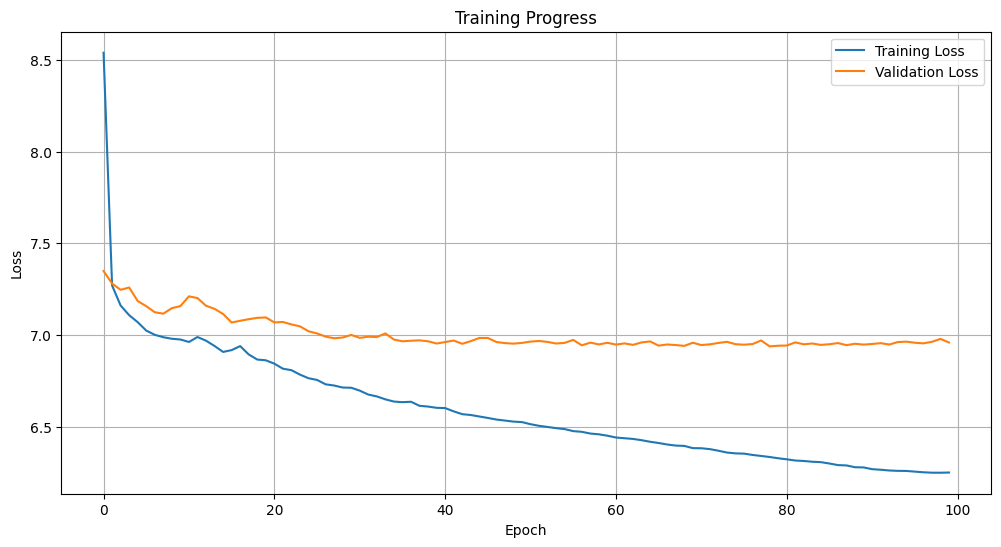

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f"Training Progress")
plt.legend()
plt.grid(True)
plt.show()

In [32]:
spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "lemmatizer"])

def clean_text(text):
    text = unescape(str(text))
    text = re.sub(r'<\/?[a-zA-Z_]+\b[^>]*>', '', text, flags=re.IGNORECASE)
    text = re.sub(r'&\w+;', '', text)
    text = re.sub(r'[<>]', '', text)

    text = text.replace('"', "'")
    allowed_punct = r"!?.,:;'"
    text = re.sub(fr"[^\w\s{allowed_punct}]", '', text)
    text = re.sub(r"\s+([!?,.])\s+", r" \1 ", text)
    text = re.sub(r"\s{2,}", " ", text).strip()
    return text

def normalize_text(text, is_title=False):
    if is_title:
        text = re.sub(r'\b([A-Z]{2,})\b', r'<KEEP_CAPS>\1</KEEP_CAPS>', text)
        text = titlecase(text.lower())
        text = re.sub(r'<KEEP_CAPS>(.*?)</KEEP_CAPS>', lambda m: m.group(1).upper(), text)
        return text
    else:
        return text.lower()

def spacy_tokenize(text, nlp):
    doc = nlp(text)
    punct_set = {".", ",", "!", "?", ":", ";", "'"}
    tokens = []
    for token in doc:
        tok_text = token.text.strip()
        if not tok_text:
            continue
        if token.is_stop:
            continue
        if '_' in tok_text:
            continue
        if tok_text in punct_set:
            tokens.append(tok_text)
            continue
        if re.match(r'^[a-z0-9]+$', tok_text) and len(tok_text) >= 2:
            tokens.append(tok_text)
    return tokens

def text_to_sequence(tokens, vocab):
    return [vocab.get('<start>', 1)] \
        + [vocab.get(tok, vocab.get('<unk>', 1)) for tok in tokens] \
        + [vocab.get('<end>', 1)]

def process_inference_desc(text, vocab, nlp):
    # 1) clean
    text = clean_text(text)
    # 2) normalize (desc => is_title=False)
    text = normalize_text(text, is_title=False)
    # 3) spacy tokenize
    tokens = spacy_tokenize(text, nlp)
    # 4) map to sequence with <start> / <end>
    tokens = [tok if tok in vocab else '<unk>' for tok in tokens]
    seq = text_to_sequence(tokens, vocab)
    if len(seq) > 20:
        seq = seq[:19] + [vocab['<end>']] 
    return seq

In [33]:
# def greedy_decode(model, src, src_key_padding_mask, max_len=20):
#     """Enhanced greedy decoding with correct special token handling"""
#     model.eval()
#     device = src.device
#     batch_size = src.size(0)
#     eos_idx = model.config.eos_idx
#     sos_idx = model.config.sos_idx
# 
#     # make sure src_key_padding_mask is boolean
#     src_key_padding_mask = src_key_padding_mask.to(torch.bool)
# 
#     # src encoding
#     memory = model.encode(src, src_key_padding_mask=src_key_padding_mask)
# 
#     # initialize target with <start>
#     tgt = torch.full((batch_size, 1), sos_idx, dtype=torch.long, device=device)
# 
#     # initialize unfinished sequences
#     unfinished = torch.ones(batch_size, dtype=torch.bool, device=device)
#     final_outputs = [[] for _ in range(batch_size)]
# 
#     for step in range(max_len):
#         tgt_mask = model.generate_tgt_mask(tgt.size(1)).to(device)
# 
#         # decode step
#         logits = model.decode(
#             tgt=tgt,
#             memory=memory,
#             tgt_mask=tgt_mask,
#             memory_key_padding_mask=src_key_padding_mask
#         )  # [B, T, V]
# 
#         # get next token
#         next_tokens = logits[:, -1, :].argmax(-1)  # [B]
# 
#         # update target sequence
#         for i in range(batch_size):
#             if unfinished[i]:
#                 final_outputs[i].append(next_tokens[i].item())
# 
#         eos_hit = (next_tokens == eos_idx)
#         unfinished = unfinished & ~eos_hit
# 
#         # early exit if all sequences have ended
#         if not unfinished.any():
#             break
# 
#         tgt = torch.cat([
#             tgt[unfinished],
#             next_tokens[unfinished].unsqueeze(1)
#         ], dim=1)
# 
#     # remover token after <end>
#     results = []
#     for seq in final_outputs:
#         if eos_idx in seq:
#             eos_pos = seq.index(eos_idx)
#             seq = seq[:eos_pos]
#         results.append(seq)
# 
#     return results

In [34]:
def beam_decode(
        model,
        src: torch.Tensor,
        src_key_padding_mask: torch.Tensor,
        max_len: int = 20,
        beam_size: int = 5,
        length_penalty: float = 0.6
) -> list:
    """
    Beam search decoding with length penalty.
    
    Args:
        model: Transformer model.
        src: Source sequence tensor of shape [1, src_len] (batch_size=1).
        src_key_padding_mask: Padding mask tensor for the source [1, src_len].
        beam_size: Beam width.
        length_penalty: Length penalty coefficient (0.0 ~ 1.0, larger values favor longer sequences).
    
    Returns:
        List[List[int]]: A list of decoded sequences (list length equals beam_size).
    """
    model.eval()
    device = src.device
    eos_idx = model.config.eos_idx
    sos_idx = model.config.sos_idx

    # Encode the source sequence
    memory = model.encode(src, src_key_padding_mask=src_key_padding_mask)  # [1, S, D]

    # Initialize the beam with a dictionary representing the initial candidate
    beams = [
        {
            'tokens': [sos_idx],
            'score': 0.0,
            'finished': False
        }
    ]

    for step in range(max_len):
        candidates = []
        for beam in beams:
            if beam['finished']:
                candidates.append(beam)
                continue

            # decoder input with the current token sequence [1, current_len]
            tgt = torch.tensor([beam['tokens']], dtype=torch.long, device=device)
            tgt_mask = model.generate_tgt_mask(tgt.size(1)).to(device)

            # Decode to obtain logits
            logits = model.decode(
                tgt=tgt,
                memory=memory,
                tgt_mask=tgt_mask,
                memory_key_padding_mask=src_key_padding_mask
            )  # [1, T, V]

            # Get logits from the last time step and compute log probabilities
            log_probs = torch.log_softmax(logits[0, -1], dim=-1)  # [V]
            topk_probs, topk_indices = torch.topk(log_probs, beam_size)  # [beam_size]

            # Generate new candidate beams
            for i in range(beam_size):
                token = topk_indices[i].item()
                score = beam['score'] + topk_probs[i].item()
                new_beam = {
                    'tokens': beam['tokens'] + [token],
                    'score': score,
                    'finished': (token == eos_idx)
                }
                candidates.append(new_beam)

        # Sort candidates by score with length penalty and keep the top beam_size candidates
        candidates.sort(key=lambda x: x['score'] / ((1 + len(x['tokens'])) ** length_penalty), reverse=True)
        beams = candidates[:beam_size]

        # If all beams have finished decoding, exit early.
        if all(beam['finished'] for beam in beams):
            break

    # Post-processing: remove the <start> token and truncate tokens after <end>
    results = []
    for beam in beams:
        tokens = beam['tokens'][1:]  
        if eos_idx in tokens:
            eos_pos = tokens.index(eos_idx)
            tokens = tokens[:eos_pos]
        results.append(tokens)

    return results

In [37]:
def predict(model, raw_text, vocab, reverse_vocab, nlp, device='cuda',
            max_input_len=200, max_target_len=20, beam_size=5):
    # process inference description
    content_tokens = process_inference_desc(raw_text, vocab, nlp)

    # convert to tensor
    input_seq = torch.tensor(content_tokens, dtype=torch.long).unsqueeze(0).to(device)  # [1, S]

    # padding
    if input_seq.size(1) < max_input_len:
        pad = torch.full((1, max_input_len - input_seq.size(1)), vocab['<pad>'],
                         dtype=torch.long, device=device)
        input_seq = torch.cat([input_seq, pad], dim=1)
    else:
        input_seq = input_seq[:, :max_input_len]
        input_seq[0, -1] = vocab['<end>']  # make sure the last token is <end>

    # generate src_key_padding_mask
    src_pad_mask = (input_seq == vocab['<pad>'])

    # generate output sequence
    with torch.no_grad():
        output_seqs = beam_decode(
            model=model,
            src=input_seq,
            src_key_padding_mask=src_pad_mask,
            max_len=max_target_len,
            beam_size=beam_size
        )

    # convert index to tokens
    tokens = []
    for idx in output_seqs[0]:  # output_seqs[0] 
        token = reverse_vocab.get(idx, '<unk>')
        if token == '<end>':
            break
        tokens.append(token)

    text = ' '.join(tokens)
    text = re.sub(r'\s+([.,!?;:])', r'\1', text)  # remove space before punctuation
    text = re.sub(r'([.,!?;:])\s+', r'\1 ', text)  # space after punctuation
    return text.capitalize()

In [38]:
test_text_1 = "tokyo ap a lunar orbiter that japan had planned to launch this year could face further delays, possibly until next year or later, because of a funding shortfall and problems developing the probe's informationgathering capabilities, japan's space agency said wednesday. the japan aerospace exploration agency, or jaxa, released a report to a governmentrun commission explaining expected delays to the launch of the 135 million lunara probe..."
test_text_2 = "advanced micro devices inc.'s amd inc.'s 90nanometer notebook processors are on their way to customers, according to a research note published by goldman sachs co. thursday.advertisementintroducing ibm eserver p5 systems.powered by ibms most advanced 64bit microprocessor power5tm, p5 systems can run unix and linux simultaneously. learn more about eserver p5 systems."

for i, test_text in enumerate([test_text_1, test_text_2], start=1):
    pred_title = predict(model, test_text, vocab, reverse_vocab, nlp, device=device)

    print(f"===== Input {i} =====")
    print("Original text (desc):", test_text)
    print("Predicted Title:", pred_title)

===== Input 1 =====
Original text (desc): tokyo ap a lunar orbiter that japan had planned to launch this year could face further delays, possibly until next year or later, because of a funding shortfall and problems developing the probe's informationgathering capabilities, japan's space agency said wednesday. the japan aerospace exploration agency, or jaxa, released a report to a governmentrun commission explaining expected delays to the launch of the 135 million lunara probe...
Predicted Title: <unk>, <unk>
===== Input 2 =====
Original text (desc): advanced micro devices inc.'s amd inc.'s 90nanometer notebook processors are on their way to customers, according to a research note published by goldman sachs co. thursday.advertisementintroducing ibm eserver p5 systems.powered by ibms most advanced 64bit microprocessor power5tm, p5 systems can run unix and linux simultaneously. learn more about eserver p5 systems.
Predicted Title: <unk>, <unk>
